<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/currrent/AK_GPT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


* Consider the following thins:
  * GPU usage if available

* Dataset creation
  *   Download https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
  *   create ITOS and STOI from it (including encode/decode functions)
  * create a train and a val set and visualize the relationship of X and Y ("When input is xxxx the target is: yyyy")
* Helper functions
  * Create a get_batch(split) and a estimate_loss() [Estimates the loss for trian and val and] function

* Model (I)
  * Create a simple Bi-gram model with a forward()- and generate()- function
  * Create a training loop and train the Bi-gram Model
  * Generate a sequence of X tokens from the trained model

* Model (II)
  * Create a second "GPT"-like model with a forward()- and generate()- function
    * ...with a token embedding table
    * ...with a positional encoding table
    * ...with a sequence of Attention-Blocks that consist of
        * ...MultiHeadAttention(n_head, head_size)
          * with Head_s(), a linear Layer and dropout (Head is an attention head)
        * ...FeedForward(?)
          * with 4 times the hidden layers and Dropout
        * ...Layernorm(?)


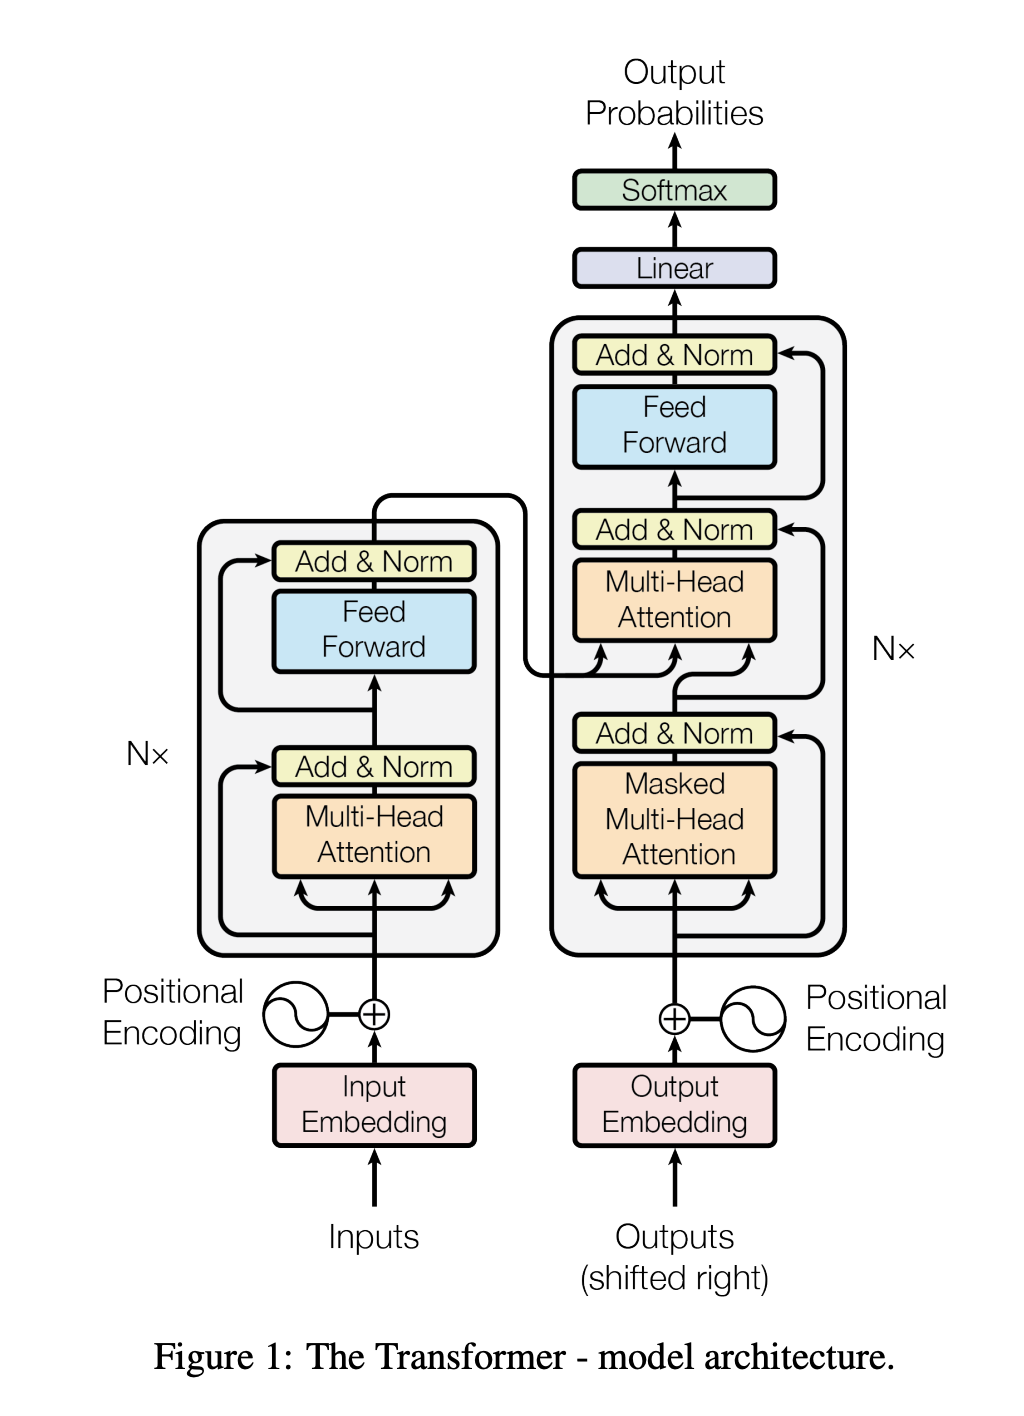


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
###########################################
#           CREATE THE DATASET            #
###########################################

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-04-22 22:10:16--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  4.34MB/s    in 0.2s    

2025-04-22 22:10:17 (4.34 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [4]:
with open("input.txt", "r") as f:
  text = f.read()
text[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [5]:
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print(vocab_size)

65


In [6]:
stoi = {v:k for k,v in enumerate(vocab)}
itos = {k:v for k,v in enumerate(vocab)}

encode = lambda val:  [stoi[x] for x in val]
decode = lambda val:  "".join(itos[x] for x in val)

encoded_text = encode("Hello there!")
print(encoded_text)
decoded_text = decode(encoded_text)
print(decoded_text)

[20, 43, 50, 50, 53, 1, 58, 46, 43, 56, 43, 2]
Hello there!


In [7]:
data = torch.tensor(encode(text), dtype=torch.long)
split = int(len(data) * 0.9)
train = data[:split]
val = data[split:]

In [8]:
len(train), len(val)

(1003854, 111540)

In [9]:
block_size = 8
example = data[:block_size + 1]
for i in range(block_size):
  print(f"When input is: {example[:i+1]}")
  print(f"Then ouput is: {example[i+1]}")


When input is: tensor([18])
Then ouput is: 47
When input is: tensor([18, 47])
Then ouput is: 56
When input is: tensor([18, 47, 56])
Then ouput is: 57
When input is: tensor([18, 47, 56, 57])
Then ouput is: 58
When input is: tensor([18, 47, 56, 57, 58])
Then ouput is: 1
When input is: tensor([18, 47, 56, 57, 58,  1])
Then ouput is: 15
When input is: tensor([18, 47, 56, 57, 58,  1, 15])
Then ouput is: 47
When input is: tensor([18, 47, 56, 57, 58,  1, 15, 47])
Then ouput is: 58


In [10]:
###########################################
#            BATCHING AND LOSS            #
###########################################

In [11]:
batch_size = 32
eval_iters = 500

def get_batch(split):

  dataset = train if split == "train" else val
  X, Y = [], []
  idx = torch.randint(0, len(dataset) - block_size, (batch_size,))
  xb = torch.stack([dataset[i:i+block_size] for i in idx],0)
  yb = torch.stack([dataset[i+1:i+block_size+1] for i in idx],0)
  xb, yb = xb.to(device), yb.to(device)
  return xb, yb

@torch.no_grad()
def estimate_loss():
  out = {}

  model.eval()

  for split in ["train", "val"]:
    losses = torch.zeros(eval_iters)
    for i in range(eval_iters):
      xb, yb = get_batch(split)
      logits, loss = model(xb, yb)
      losses[i] = loss.item()
    mean_loss = losses.mean()
    out[split] = mean_loss

  model.train()

  return out

xb, yb = get_batch("train")
for b in range(batch_size):
  for t in range(block_size):
    context = xb[b, :t+1]
    target = yb[b, t]
    print(context)
    print(target)


tensor([24])
tensor(43)
tensor([24, 43])
tensor(58)
tensor([24, 43, 58])
tensor(5)
tensor([24, 43, 58,  5])
tensor(57)
tensor([24, 43, 58,  5, 57])
tensor(1)
tensor([24, 43, 58,  5, 57,  1])
tensor(46)
tensor([24, 43, 58,  5, 57,  1, 46])
tensor(43)
tensor([24, 43, 58,  5, 57,  1, 46, 43])
tensor(39)
tensor([44])
tensor(53)
tensor([44, 53])
tensor(56)
tensor([44, 53, 56])
tensor(1)
tensor([44, 53, 56,  1])
tensor(58)
tensor([44, 53, 56,  1, 58])
tensor(46)
tensor([44, 53, 56,  1, 58, 46])
tensor(39)
tensor([44, 53, 56,  1, 58, 46, 39])
tensor(58)
tensor([44, 53, 56,  1, 58, 46, 39, 58])
tensor(1)
tensor([52])
tensor(58)
tensor([52, 58])
tensor(1)
tensor([52, 58,  1])
tensor(58)
tensor([52, 58,  1, 58])
tensor(46)
tensor([52, 58,  1, 58, 46])
tensor(39)
tensor([52, 58,  1, 58, 46, 39])
tensor(58)
tensor([52, 58,  1, 58, 46, 39, 58])
tensor(1)
tensor([52, 58,  1, 58, 46, 39, 58,  1])
tensor(46)
tensor([25])
tensor(17)
tensor([25, 17])
tensor(27)
tensor([25, 17, 27])
tensor(10)
tensor([25

In [12]:
a = torch.randn((2,3))
b = torch.randn((2,3))

print(a)

torch.cat((a, b), 0)

tensor([[-1.2221,  1.5787,  0.5397],
        [ 1.1634,  0.6947, -1.2307]])


tensor([[-1.2221,  1.5787,  0.5397],
        [ 1.1634,  0.6947, -1.2307],
        [ 0.6871,  1.1841, -0.2909],
        [ 1.5433,  1.8641,  1.6099]])

In [13]:
###########################################
#           Simple Bigram Model           #
###########################################

In [30]:
epochs = 5000
learning_rate = 1e-03
n_embed = 384
head_size = 32
n_heads = 6
n_layer = 6
dropout = 0.2
batch_size = 64
block_size = 256
eval_iters = 200

In [34]:
class BigramModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, x, targets=None):
    x = self.embedding_table(x)

    if targets is None:
      loss = None
      logits = x
    else:
      B, T, C = x.shape
      logits = x.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, context, max_new_tokens):
    out = []
    for _ in range(max_new_tokens):
      logits, _ = self.forward(context)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim=1)
      idx = torch.multinomial(probs, 1)
      out.append(idx.item())
      context = torch.cat((context, idx), dim=1)

    return out


class Head(nn.Module):

  def __init__(self, head_size):
    super().__init__()
    self.head_size = head_size
    self.k = nn.Linear(n_embed, head_size, bias=False)
    self.q = nn.Linear(n_embed, head_size, bias=False)
    self.v = nn.Linear(n_embed, head_size, bias=False)
    self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, T, C = x.shape
    q = self.q(x)   # (B, T, C)
    k = self.k(x)   # (B, T, C)
    v = self.v(x)   # (B, T, C)

    wei = q @ k.transpose(-2, -1) * C**-0.5 # (B, T, C) @ (B, C, T) --> (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # (B, T, T)
    wei = F.softmax(wei, dim=1) # (B, T, T)
    wei = self.dropout(wei)
    out = wei @ v # (B, T, T) @ (B, T, C) --> (B, T, C)

    return out

class MultiHeadAttention(nn.Module):

  def __init__(self, n_heads, head_size):
    super().__init__()
    self.sa_heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
    self.projection = nn.Linear(n_embed, n_embed)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, T, C = x.shape
    x = torch.cat([h(x) for h in self.sa_heads], dim=-1)
    x = self.projection(x)
    x = self.dropout(x)
    return x

class FeedForward(nn.Module):

  def __init__(self, size):
    super().__init__()
    self.ff = nn.Sequential(
        nn.Linear(size, 4 * size),
        nn.ReLU(),
        nn.Linear(4 * size, size),
    )
    self.dropout = nn.Dropout(dropout)


  def forward(self, x):
    x = self.ff(x)
    x = self.dropout(x)
    return x

class Block(nn.Module):

  def __init__(self, n_embed, n_heads):
    super().__init__()
    head_size = n_embed // n_heads
    self.sa_heads = MultiHeadAttention(n_heads, head_size)
    self.ff = FeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)


  def forward(self, x):
    x = x + self.sa_heads(self.ln1(x))
    x = x + self.ff(self.ln2(x))
    return x

class MyFirstTransformer(nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding_table = nn.Embedding(vocab_size, n_embed)
    self.position_encoding = nn.Embedding(block_size, n_embed)
    self.blocks = nn.Sequential(*[Block(n_embed, n_heads) for _ in range(n_layer)])
    self.ln = nn.LayerNorm(n_embed)
    self.lm_head = nn.Linear(n_embed, vocab_size)

  def forward(self, x, targets=None):
    B, T = x.shape
    # x and targets: (B, T)
    token_embedding = self.embedding_table(x) # (B, T, C)
    positional_embedding = self.position_encoding(torch.arange(T, device=device)) # (T, C)
    x = token_embedding + positional_embedding # (B, T, C)
    x = self.blocks(x)
    x = self.ln(x)
    logits = self.lm_head(x) # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, context, max_new_tokens):
    for _ in range(max_new_tokens):
      cropped_context = context[:, -block_size:] # (B, T)
      logits, _ = self(cropped_context) # (B, T, C)
      logits = logits[:, -1, :] # (B, C)
      probs = F.softmax(logits, dim=1) # (B, C)
      idx = torch.multinomial(probs, 1) # (B, 1)
      context = torch.cat((context, idx), dim=1) # (B, T + 1)

    return context

In [25]:
model = BigramModel()

In [35]:
model = MyFirstTransformer()
setup = model.to(device)
print(setup)
print(f"# of parameters: {sum((p.numel() for p in model.parameters()))/1e6} M parameters")

MyFirstTransformer(
  (embedding_table): Embedding(65, 384)
  (position_encoding): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa_heads): MultiHeadAttention(
        (sa_heads): ModuleList(
          (0-5): 6 x Head(
            (k): Linear(in_features=384, out_features=64, bias=False)
            (q): Linear(in_features=384, out_features=64, bias=False)
            (v): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (projection): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (ff): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
for i in range(epochs):
  if i % eval_iters == 0 or i == epochs - 1:
    out = estimate_loss()
    print(f"Step: {i}, Train loss: {out['train']:.4f}, Val loss: {out['val']:.4f}")
  xb, yb = get_batch("train")
  logits, loss = model(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()


In [29]:
xb, yb = get_batch("train")
logits, loss = model(xb, yb)
context = torch.zeros((1,1), dtype=torch.long, device=device)
decode(model.generate(context, 1000)[0].tolist())

"'d,sidisBuo acughe lildy thil\n\nHckeah lan thevdshat wime.\nBUSENG s te k o myould l imak' is ' the\ntorus wecot,\n\nWARUnd tiringelagrso se ourrure,\nFiobe: t pus whe pome wed Yofiet o.&Sinat.\nS: ters,Wh\n\nloyme t gorteat, Fist y t,pld marullo amplt dinauthanen\n\nRYor!\nTIZorzzWoll thinyufo\nSARTizer st gh,\nS: ffone sNG h orno-blenine,\n\nThetm thes vicisitaveyZtoZA acere,\nMBravenothin le, mistee s i'ttha matsons NTolour\nh thath gersee; thOhoves he the dWay ue palo brge l 'd hepiuledatheieLalathvar\nMeve wis:\n\nCICHanut thoot w! th iknghouithenes w's ann tedild tr bewesit on t\nOLUKIshy tor'd y a bapthse hor cownch'd h het o d\n\nKE:\nTULom tounof ero;\nIng,:\n\nT:\n\nINGKI M:\nT:\nOLaye ire hifign sik r llystAR:.\nIZABe hro, ntFlakstonghe ce m, nt' cese-he m t ifod uchigtrlze y heoustH y seisheirmy!\nA courel le meN t mg,\nWicou helthid it.\nTI mows houdwsunosay: rd, ano m thithilll;'tMy whisesthaFodis preaulik'l to hererou, tepr witthin:\nHARI&QUp,\n\nAUFrn'l rangsootor ars

In [ ]:
nn.Embedding(vocab_size, vocab_size)(torch.tensor([stoi["."]])).shape

torch.Size([1, 65])

In [ ]:
xb, yb = get_batch("train")
nn.Embedding(vocab_size, vocab_size)(xb).shape

torch.Size([32, 8, 65])

In [ ]:
torch.tril(torch.ones(2,3))

tensor([[1., 0., 0.],
        [1., 1., 0.]])

In [112]:
test = 4
c = "Tesla-Motor"
c[:-test]

'Tesla-M'

In [23]:
torch.cat((torch.ones(2,3), torch.ones(2,3)))

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])